In [6]:
import jax
import jax.numpy as jnp
from advi_jax import ADVI
from advi_jax.variational_distributions import MeanField, FullRank
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import distrax
import pandas as pd
import optax
import jaxopt

import logging
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger = logging.getLogger("root")
logger.addFilter(CheckTypesFilter())

In [7]:
def inference_loop(key, params, model, optimizer, n_iterations, n_samples):
    def one_step(carry, key):
        params, state, data = carry
        value, grads = model.value_and_grad_fun(key, params, data, n_samples)
        updates, state = optimizer.update(grads, state)
        params = optax.apply_updates(params, updates)
        return (params, state, data), value

    keys = jax.random.split(key, n_iterations)
    state = optimizer.init(params)
    carry = (params, state, model.data)
    one_step = jax.jit(one_step, static_argnums=2)
    (params, state, data), values = jax.lax.scan(one_step, carry, keys)

    return values, params

## Mean Field

real mean: [1. 2.]
estimated mean: [1.0170679 1.8859973]

real var: 
[[1.8 1. ]
 [1.  2.4]]
estimated var: [0.8780087 1.0118549]



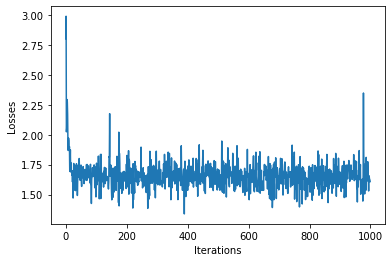

In [9]:
gt_mean = jnp.array([1.0, 2.0])
gt_cov = jnp.array([[1.8, 1.0], [1.0, 2.4]])

prior_dist = distrax.MultivariateNormalFullCovariance(gt_mean, gt_cov)

likelihood_log_prob_fun = lambda a, b, **params: 0.0
model = ADVI(prior_dist, likelihood_log_prob_fun, data=None)

variational_dist = MeanField(u_mean=jnp.array([1.5, 4.0]), u_scale=jnp.array([0.5, 0.1]))

key = jax.random.PRNGKey(1)
tx = optax.adam(learning_rate=0.1)

params = {"variational_dist": variational_dist}

losses, params = inference_loop(key, params, model, tx, n_iterations=1000, n_samples=10)

plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Losses')

post_dist = params['variational_dist']

print(f"real mean: {gt_mean}")
print(f"estimated mean: {post_dist.u_mean}")
print()
print(f"real var: \n{gt_cov}")
print(f"estimated var: {jnp.exp(post_dist.u_scale)}\n")

## Full rank

real mean: [1. 2.]
estimated mean: [0.8772884 1.825846 ]

real cov: 
[[1.8 1. ]
 [1.  2.4]]
estimated cov: 
[[1.984487  0.8881398]
 [0.8881398 2.3194218]]



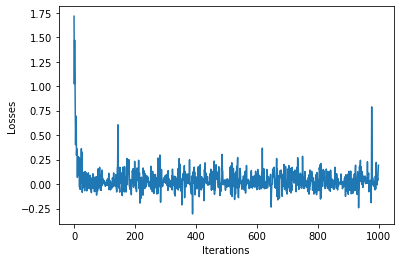

In [10]:
model = ADVI(prior_dist, likelihood_log_prob_fun, data=None)

variational_dist = FullRank(
    u_mean=jnp.array([0.1, 0.2]), u_scale_tril=jnp.array([[0.5, 0.0], [0.1, 0.5]])
)

key = jax.random.PRNGKey(1)
tx = optax.adam(learning_rate=0.1)

params = {"variational_dist": variational_dist}

losses, params = inference_loop(key, params, model, tx, n_iterations=1000, n_samples=10)

plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Losses')
    
print(f"real mean: {gt_mean}")

post_dist = params['variational_dist']._get_transformed_dist()
print(f"estimated mean: {post_dist.mean()}\n")

print(f"real cov: \n{gt_cov}")
print(f"estimated cov: \n{post_dist.covariance()}\n")